# Timeseries_02-CreateModel

This is intended to load data prepared with the script `Timeseries_01-CompileInputData.R` and create a time series model predicting groundwater levels using the [`pastas`](https://pastas.readthedocs.io/en/latest/index.html) package.

It closely follows the [example on the `pastas` website](https://pastas.readthedocs.io/en/latest/examples/001_basic_model.ipynb.html).

## Set up workspace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## Load and check input data
We have data from three nested wells:
 - `LWPH4a` = shallow alluvial aquifer
 - `LWPH4b` = deep alluvial aquifer
 - `LWPH4c` = High Plains aquifer, separated from the alluvial aquifer by a (leaky?) confining layer.
We also have data about the river stage (`stage_masl`). This is `NaN` whenever flow in the river ceases.

The data type of the series is: <class 'pandas.core.frame.DataFrame'>
Variables are:  ['prcp_mm', 'tmax_c', 'tmin_c', 'ETo_mm', 'discharge_cms', 'stage_masl', 'LWPH4a', 'LWPH4b', 'LWPH4c']


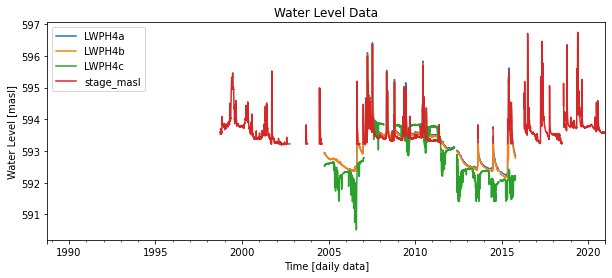

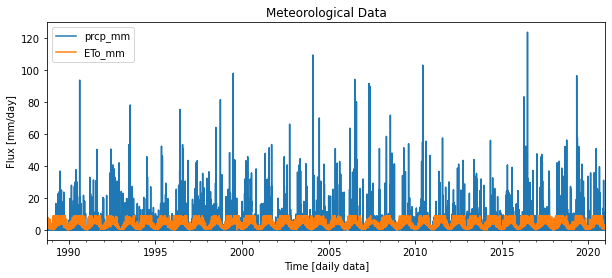

In [2]:
# Import input data time series and squeeze to Series object
inputdata = pd.read_csv('../data/Timeseries_InputData.csv', parse_dates=['date_ghcn'],
                        index_col='date_ghcn', squeeze=True)
print('The data type of the series is: %s' % type(inputdata))

# show names of columns
print('Variables are: ', list(inputdata))

# separate into water level data and meteorological data
hydrodata = inputdata[["LWPH4a", "LWPH4b", "LWPH4c", "stage_masl"]]
hydrodata.plot(figsize=(10, 4))
plt.title('Water Level Data');
plt.ylabel('Water Level [masl]');
plt.xlabel('Time [daily data]');

metdata = inputdata[["prcp_mm", "ETo_mm"]]
metdata.plot(figsize=(10, 4))
plt.title('Meteorological Data');
plt.ylabel('Flux [mm/day]');
plt.xlabel('Time [daily data]');


## Build simple model

INFO: Nan-values were removed at the start of the time series LWPH4a.
INFO: Nan-values were removed at the end of the time series LWPH4a.
INFO: Inferred frequency for time series LWPH4a: freq=D
INFO: Time Series LWPH4a: 227 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series ETo_mm: freq=D


Fit report LWPH4a                Fit Statistics
nfev     17                     EVP          42.27
nobs     3807                   R2            0.42
noise    True                   RMSE          0.44
tmin     2004-10-06 00:00:00    AIC          -3.24
tmax     2015-10-22 00:00:00    BIC          27.98
freq     D                      Obj          15.71
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A     0.811651  ±47.33%    0.138380  True
recharge_a   999.999997  ±48.42%   10.000000  True
recharge_f    -1.655759  ±35.77%   -1.000000  True
constant_d   596.501692   ±0.25%  593.137841  True
noise_alpha   45.331403  ±15.32%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.88
           recharge_f  0.58
recharge_a constant_d  0.60
recharge_f constant_d -0.55


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters'}>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>]

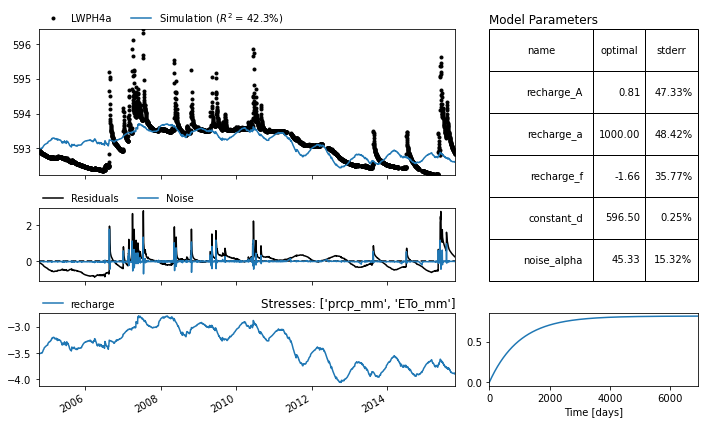

In [3]:
# calculate daily precipitation surplus (P-ETo)
precSurplus_mm = metdata["prcp_mm"] - metdata["ETo_mm"]

# Create a model object by passing it the observed series
ml_lwph4a = ps.Model(hydrodata["LWPH4a"], name="LWPH4a")

# Add the recharge data as explanatory variable
#sm_precSurplus = ps.StressModel(precSurplus_mm, ps.Gamma, name='PrecSurplus', settings="evap")
#ml_lwph4a.add_stressmodel(sm_precSurplus)

# Add the recharge data as explanatory variable
sm_rech = ps.RechargeModel(metdata["prcp_mm"], metdata["ETo_mm"], rfunc=ps.Exponential, name="recharge")
ml_lwph4a.add_stressmodel(sm_rech)

# solve
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 6))

## Add water levels in underlying HPA as an additional stress component
Based on [this example](https://pastas.readthedocs.io/en/latest/examples/004_adding_rivers.ipynb.html), but using HPA levels from well LWPH4c instead of river levels.

INFO: Nan-values were removed at the start of the time series LWPH4c.
INFO: Nan-values were removed at the end of the time series LWPH4c.
INFO: Inferred frequency for time series LWPH4c: freq=D
INFO: Time Series LWPH4c: 606 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series LWPH4c was extended to 1994-10-09 00:00:00 with the mean value of the time series.


Fit report LWPH4a                  Fit Statistics
nfev     97                     EVP            20.09
nobs     3807                   R2              0.20
noise    True                   RMSE            0.52
tmin     2004-10-06 00:00:00    AIC             2.11
tmax     2015-10-22 00:00:00    BIC            52.07
freq     D                      Obj            15.61
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           Interpolated      No

Parameters (8 were optimized)
                optimal     stderr     initial  vary
recharge_A     0.135588   ±238.54%    0.138380  True
recharge_a   184.384273   ±239.96%   10.000000  True
recharge_f    -0.010554  ±6773.77%   -1.000000  True
LWPH4c_A       1.311887    ±18.01%    1.318322  True
LWPH4c_n       0.394334    ±10.53%    1.000000  True
LWPH4c_a     781.233628    ±31.93%   10.000000  True
constant_d  -184.133495    ±75.84%  593.137841  True
noise_alpha   67.694805    ±25.97%    1.000000  True

Parameter correla

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters'}>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['LWPH4c']"}>,
 <AxesSubplot:xlabel='Time [days]'>]

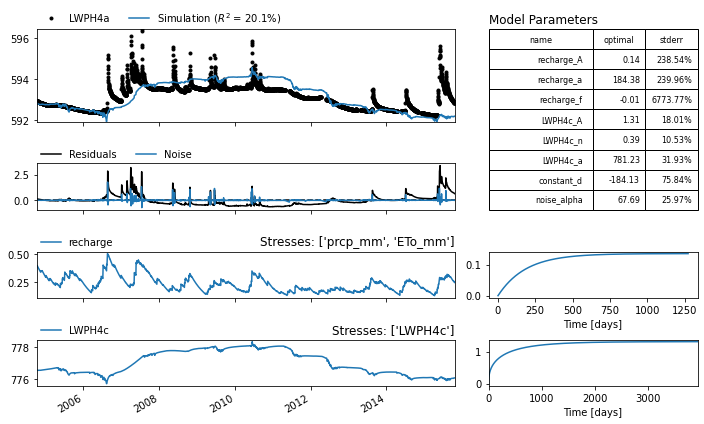

In [4]:
# add water level stress model
sm_lwph4c = ps.StressModel(hydrodata["LWPH4c"], rfunc=ps.Gamma,  name="LWPH4c",
                   settings="waterlevel")
ml_lwph4a.add_stressmodel(sm_lwph4c)

# solve
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 6))